In [1]:
!pip install svgpath2mpl

In [2]:
from collections import namedtuple, deque
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adamax
import imageio
from svgpath2mpl import parse_path
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import rotate, shift
from matplotlib.animation import FuncAnimation
from probabilistic_fire_env import ProbabilisticFireEnv
from drone_env import DronesEnv
from replay_memory import Transition
from models.drqn import DRQN
from episode_buffer import EpisodeBuffer

In [3]:
height = width = 100
BATCH_SIZE = 5
GAMMA = 0.99
INIT_SIZE = 10
TARGET_UPDATE = 1000
SAVE_POLICY = 100
EPISODE_LENGTH = 250
TRAIN_FREQ  = 10   # Number of samples to generate between trainings (Should be multiple of 10)
PRINT_FREQ  = 100  # Frequency of printing (Should be a multiple of 10)

In [4]:
height = width = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_actions = 2
screen_height = screen_width = 100
channels = 2
target_net = DRQN(device, channels, screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(torch.load('target_weights_drqn.pt'))
target_net.eval()

DRQN(
  (fc1): Sequential(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
  )
  (conv): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=30976, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=100, bias=True)


/tmp/ipykernel_32/968179313.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 5, figsize=(28, 4))


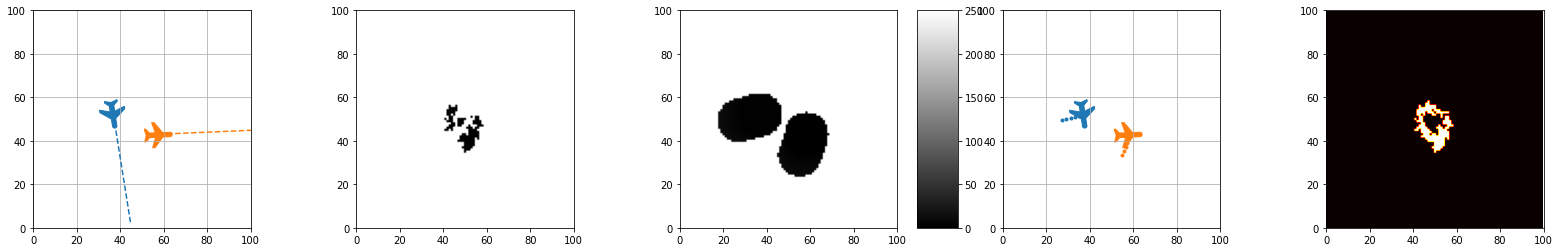

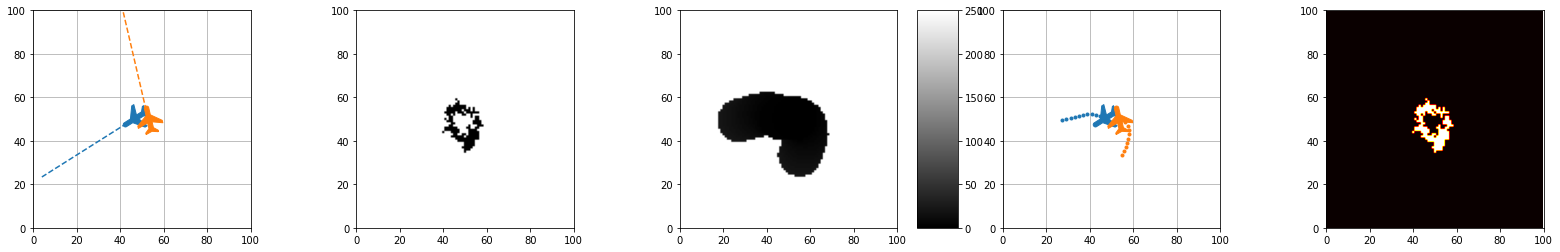

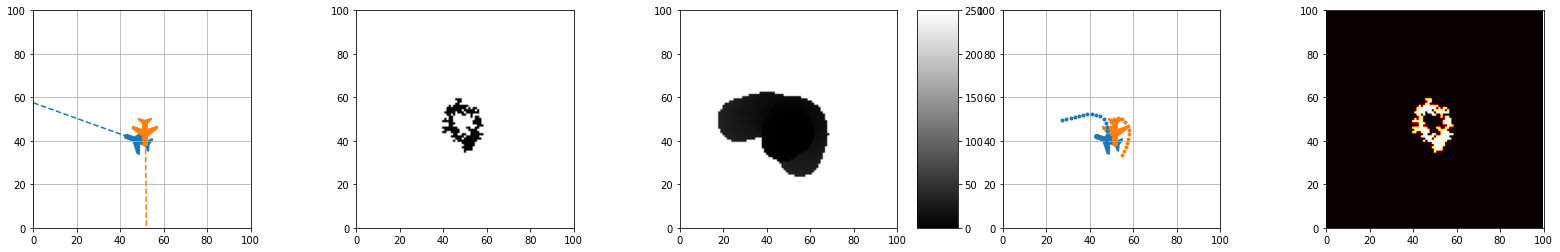

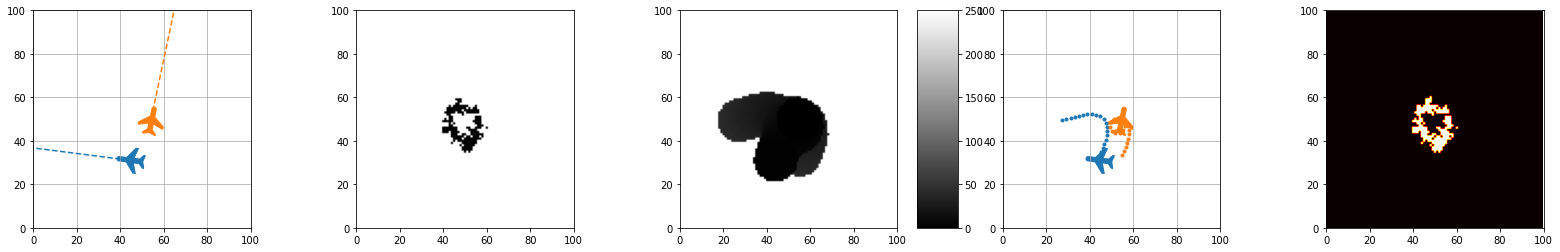

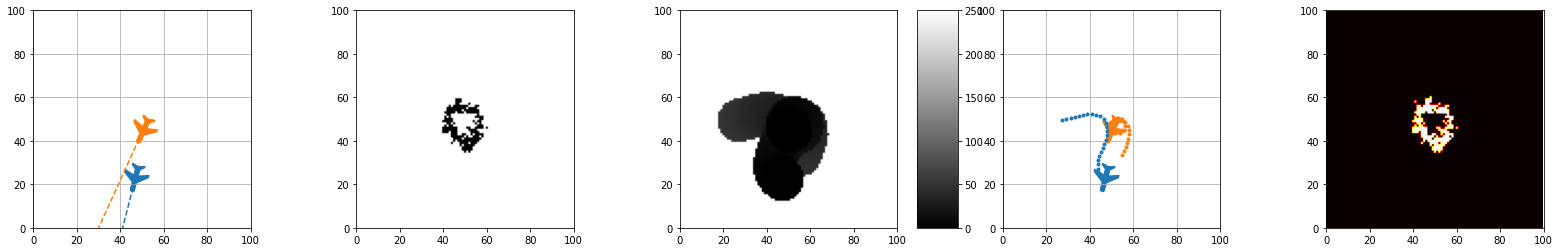

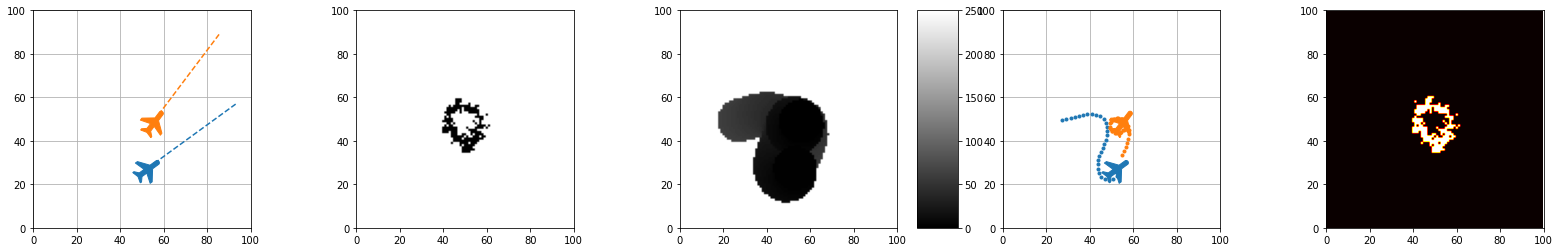

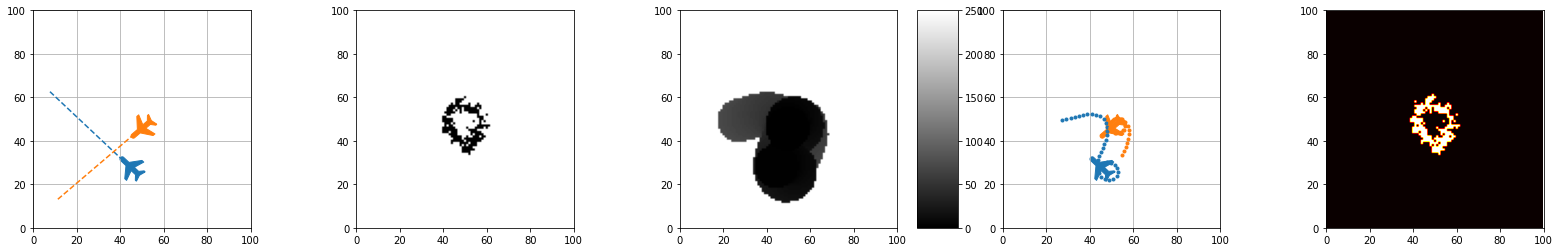

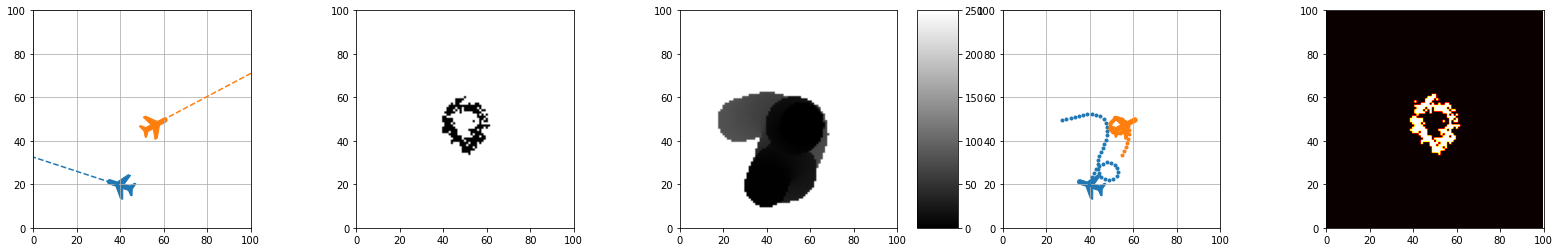

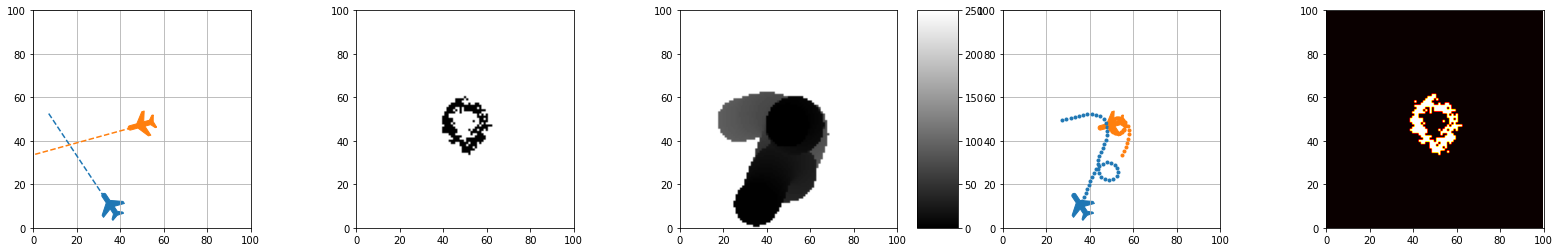

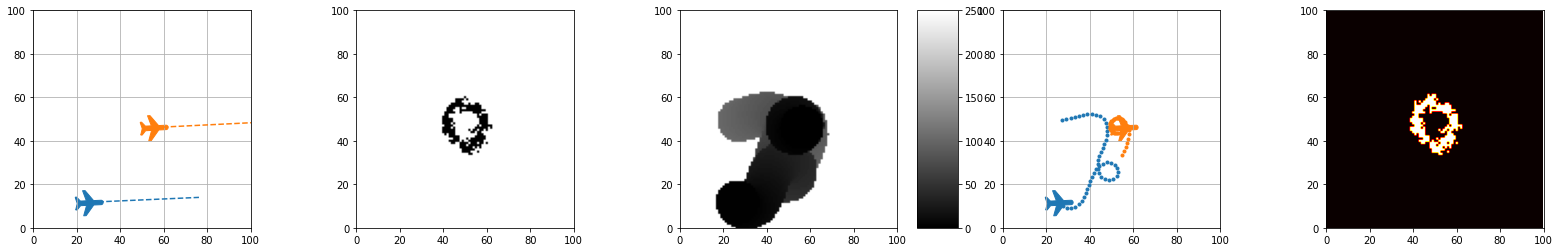

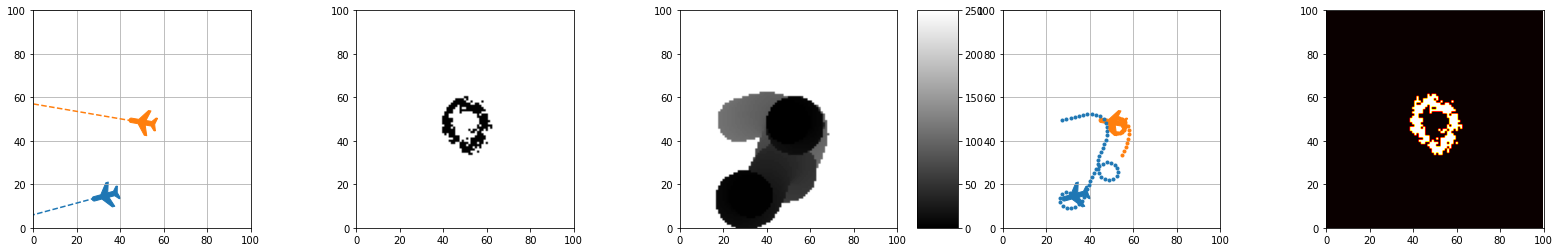

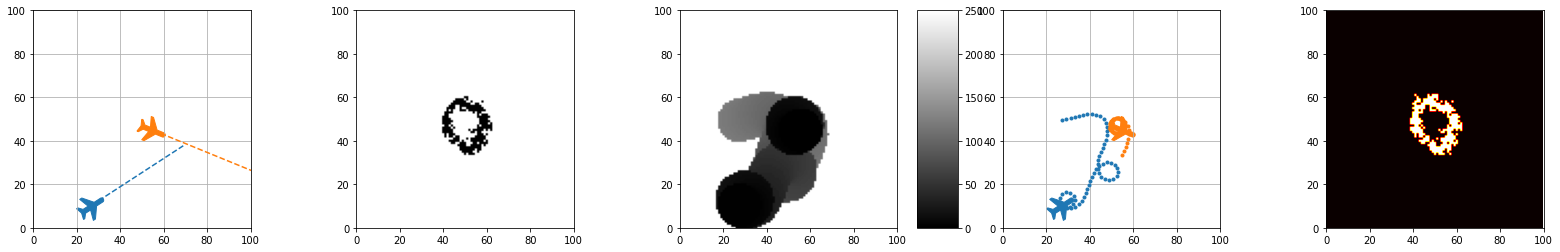

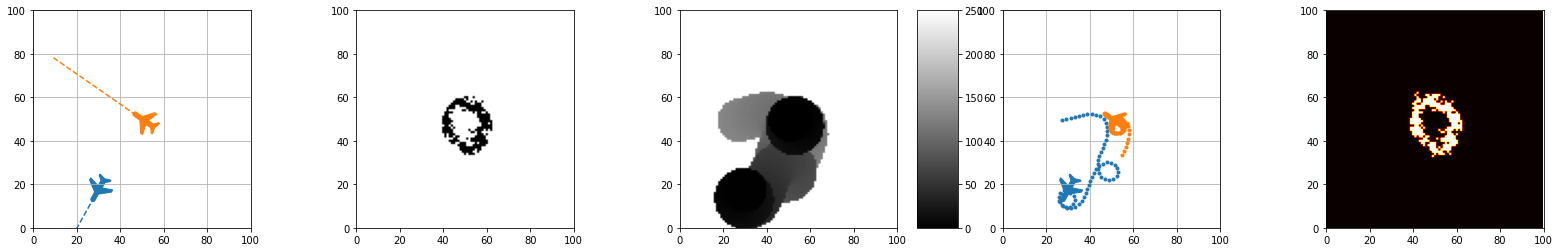

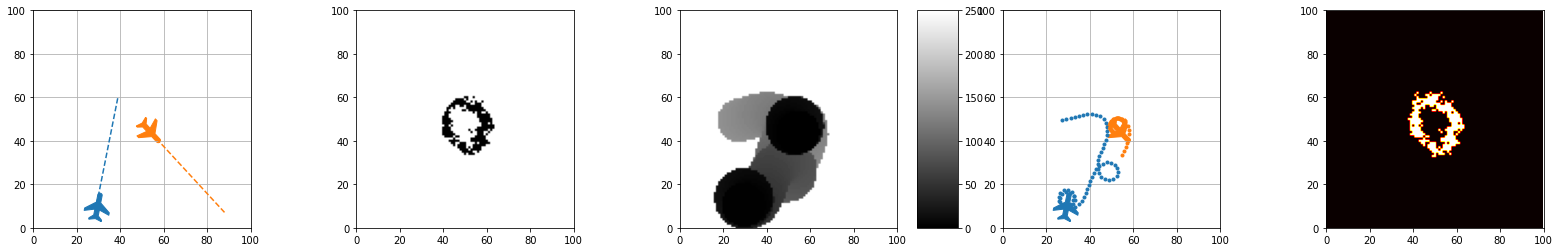

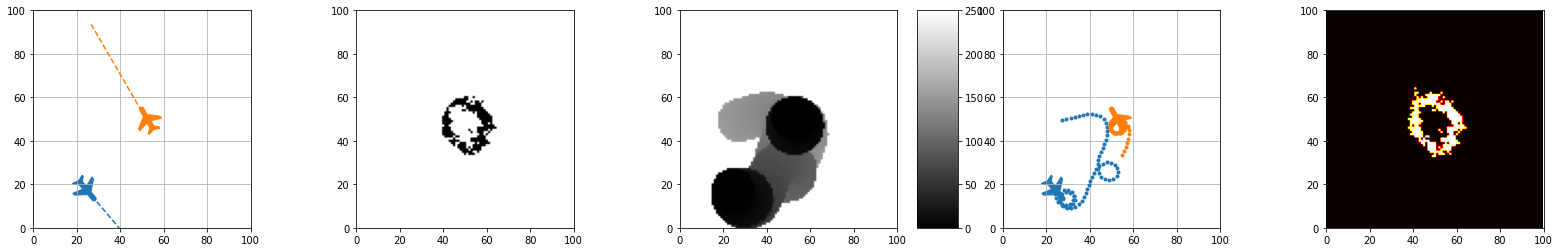

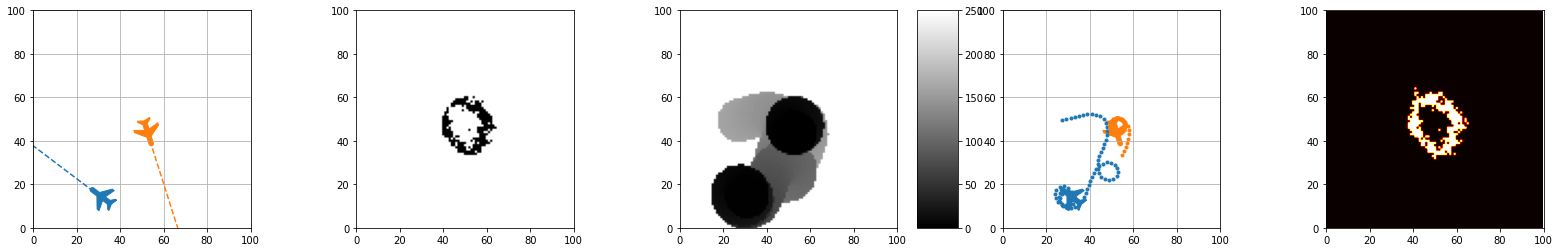

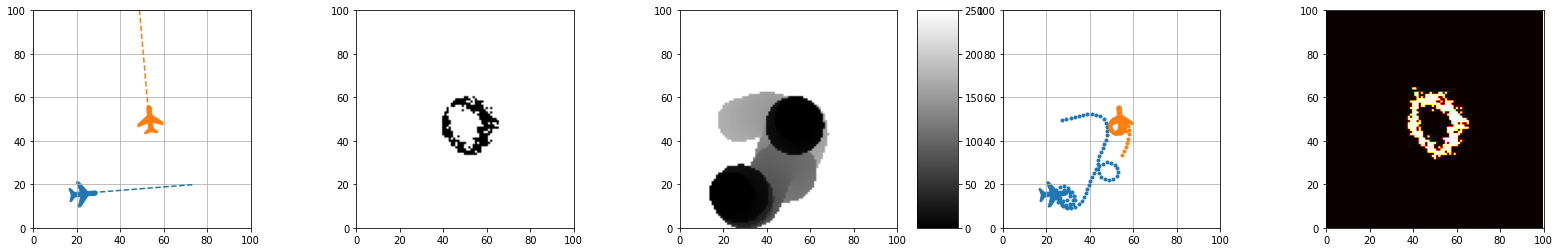

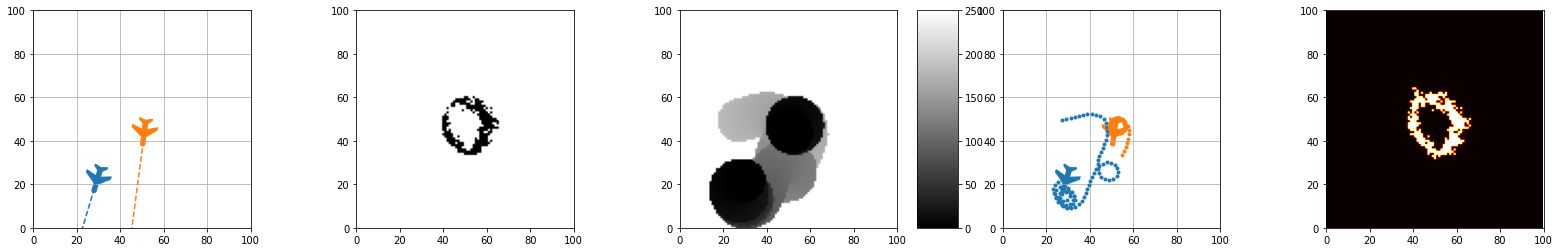

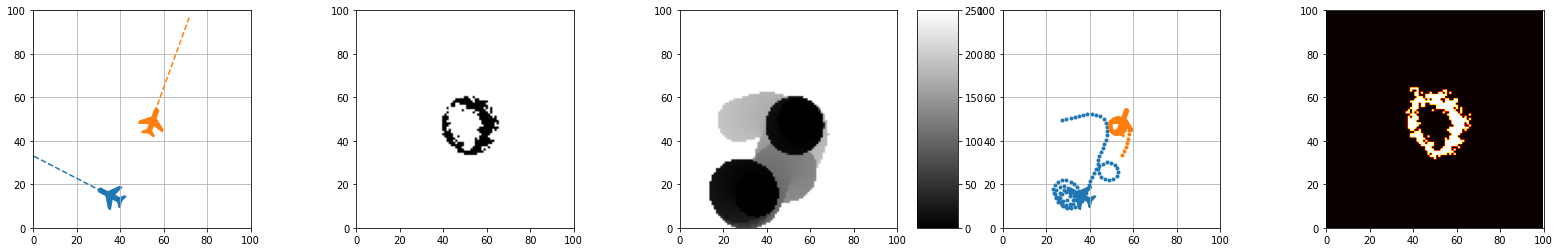

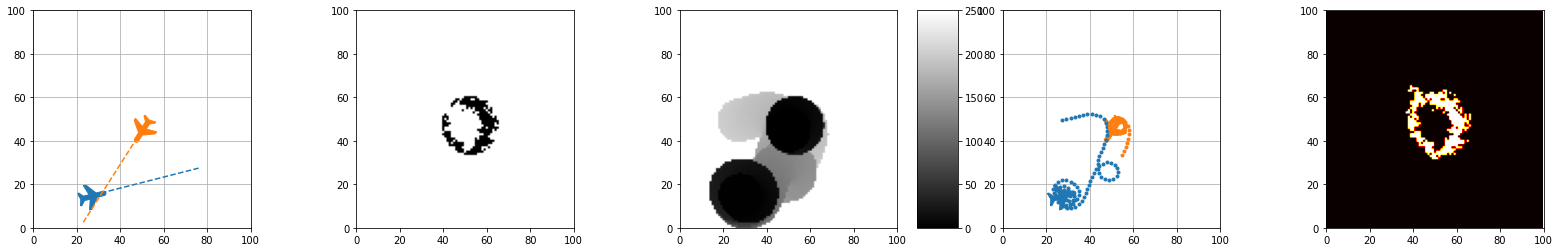

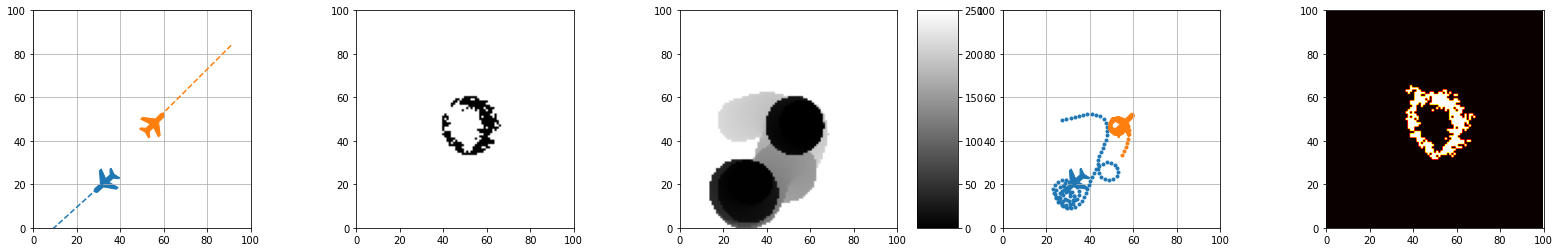

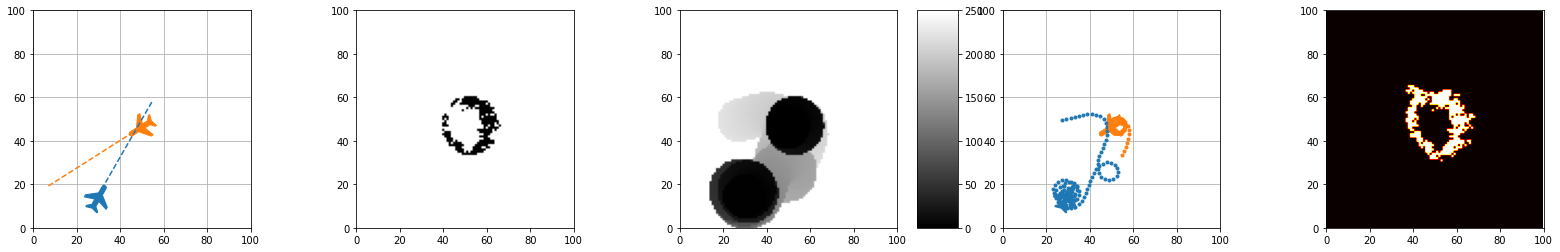

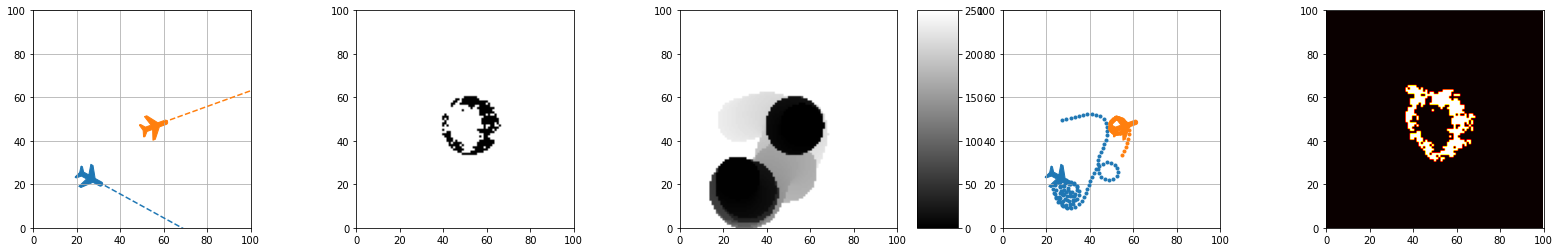

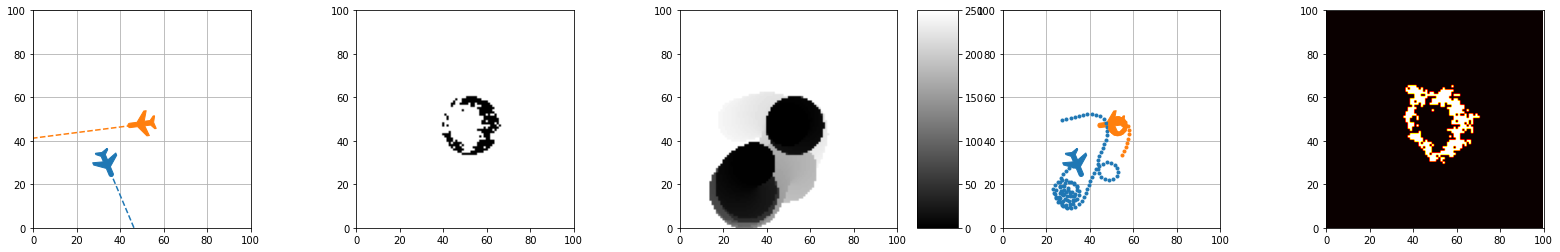

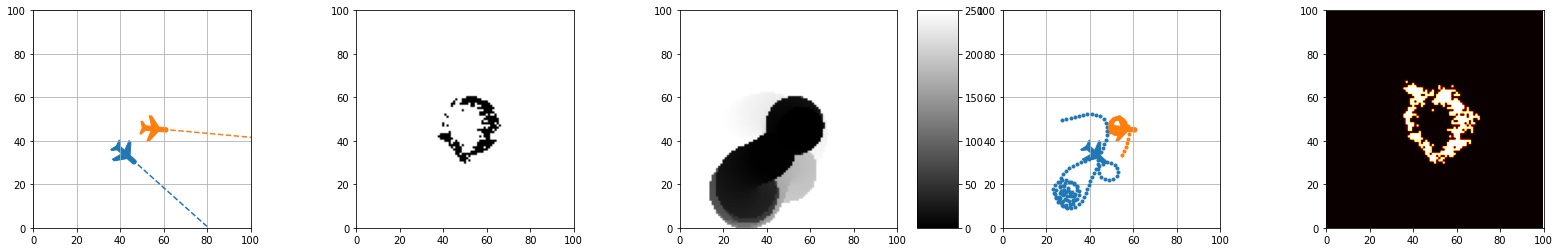

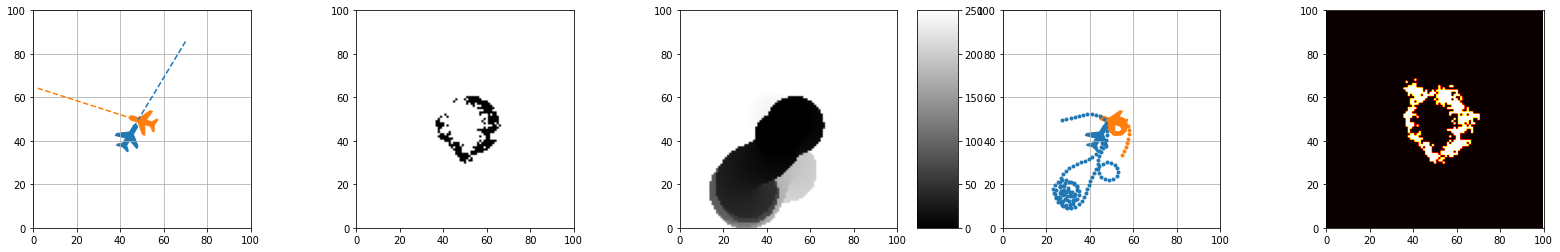

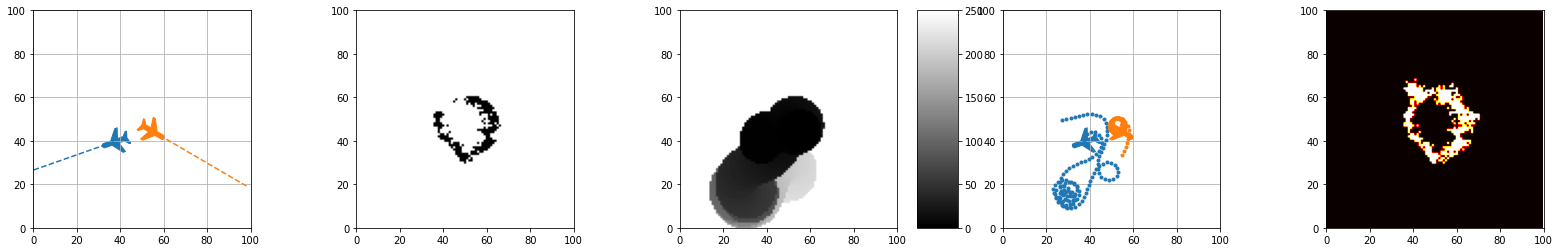

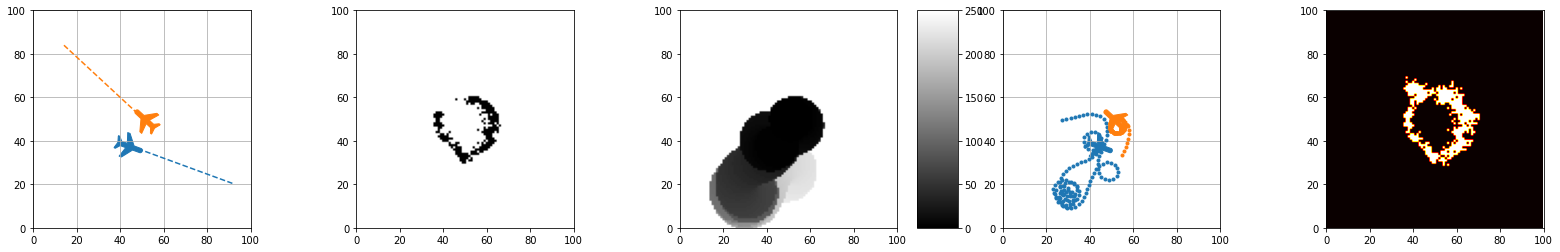

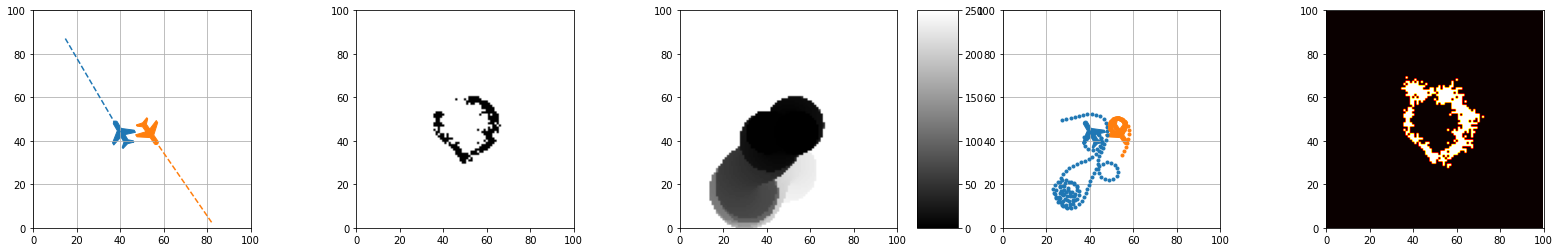

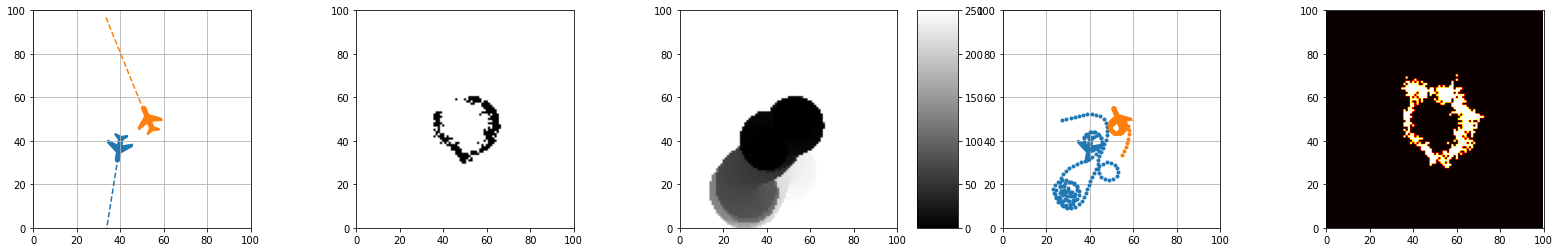

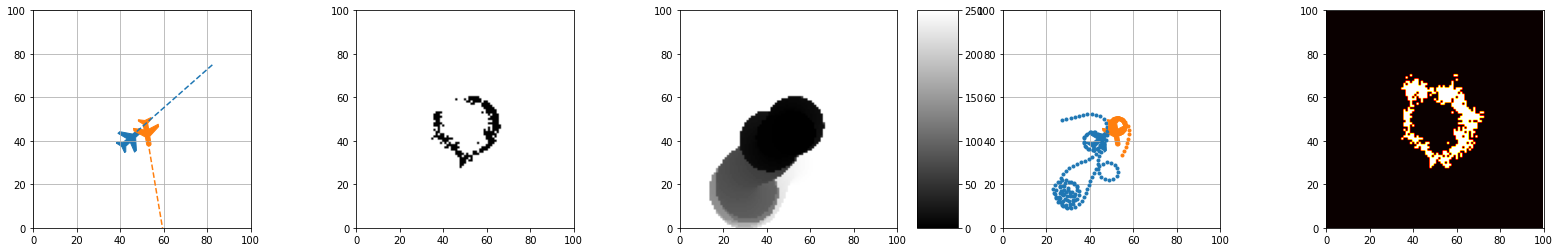

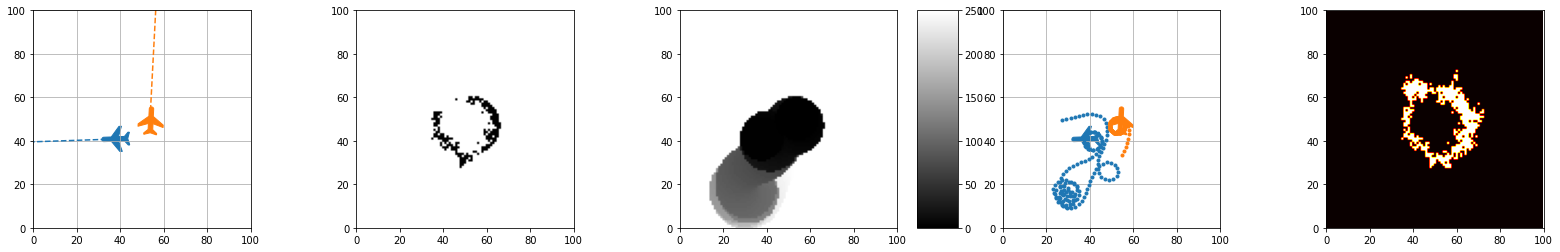

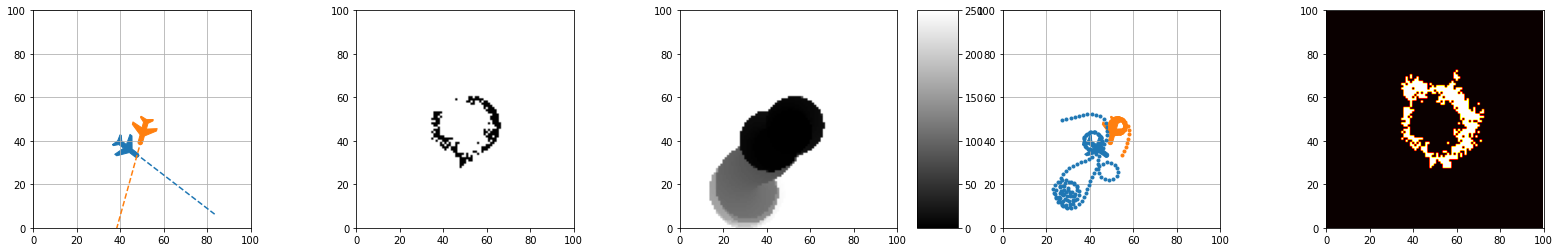

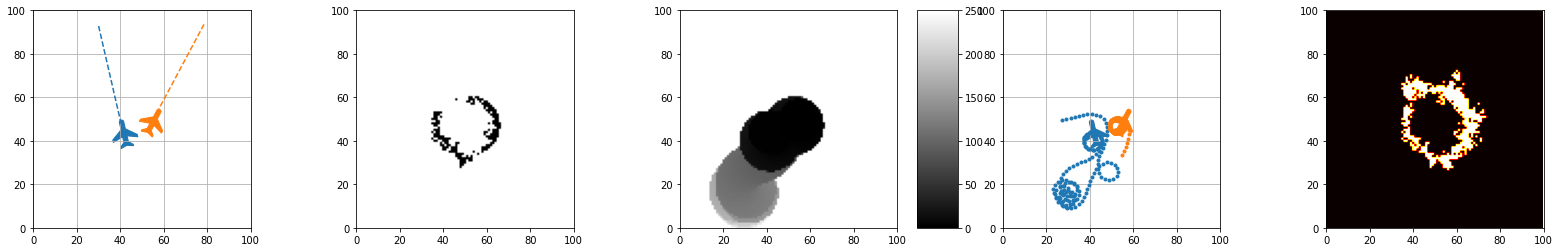

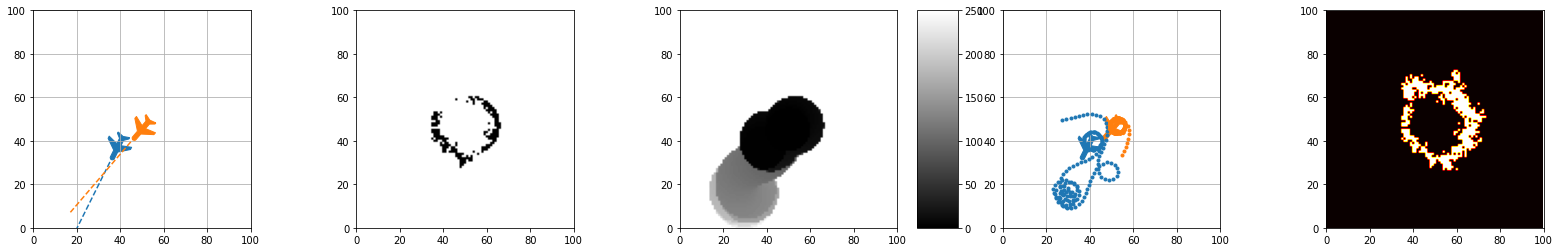

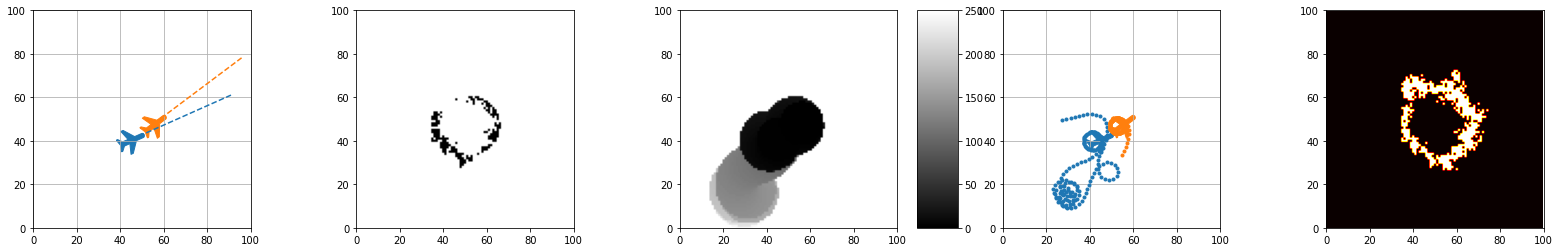

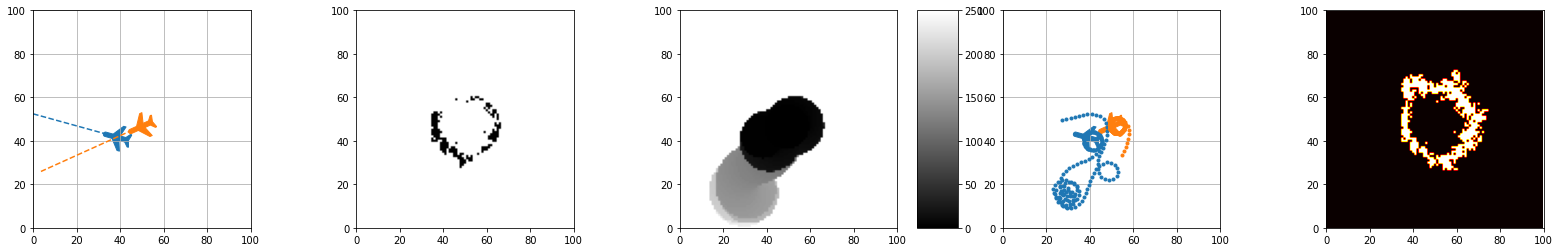

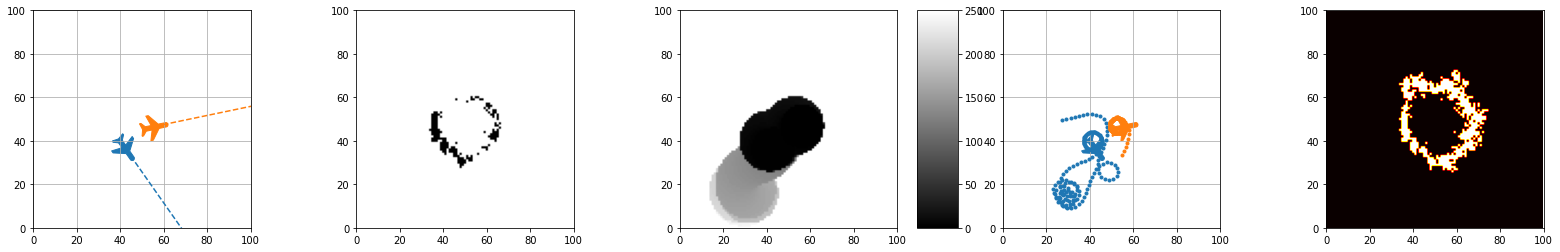

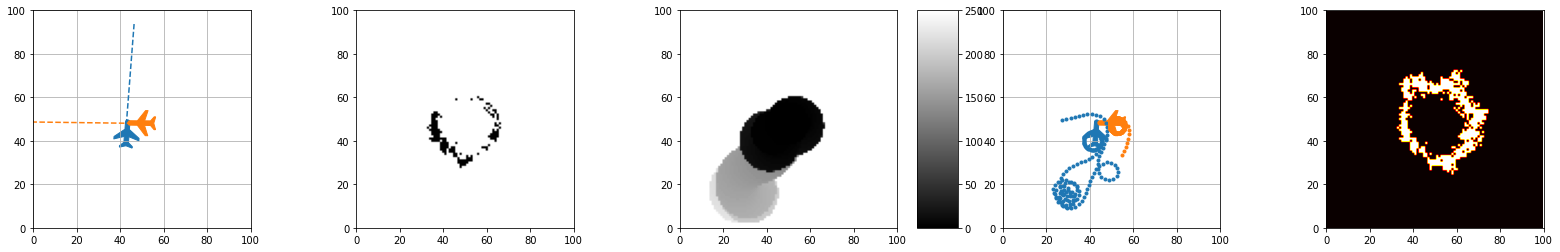

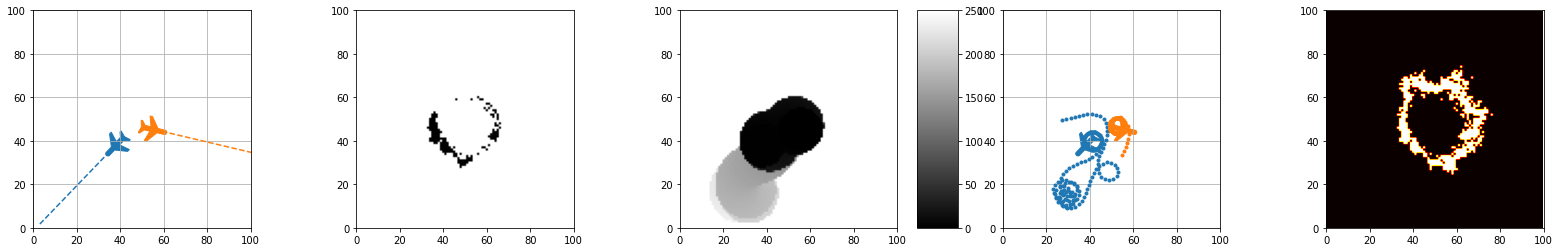

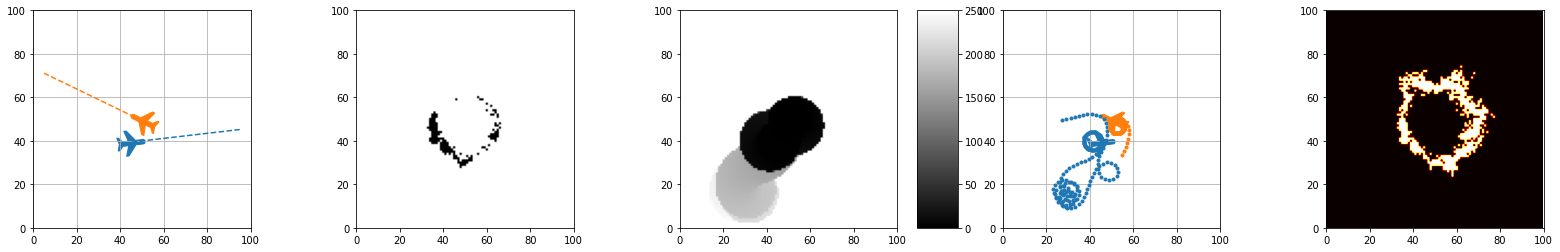

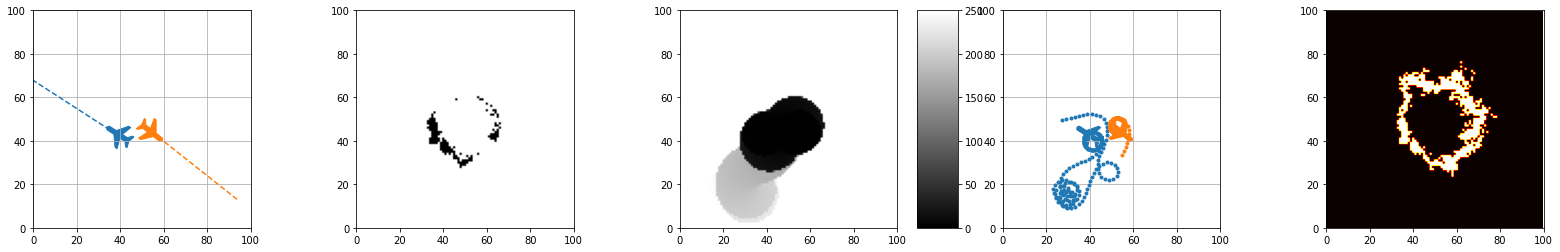

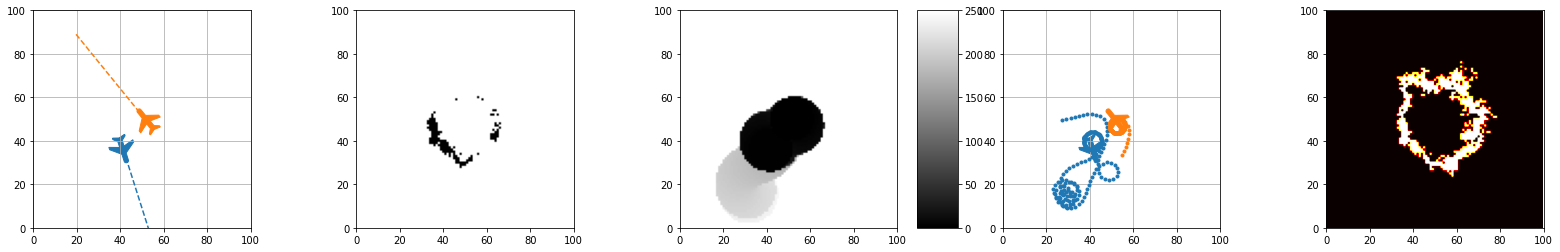

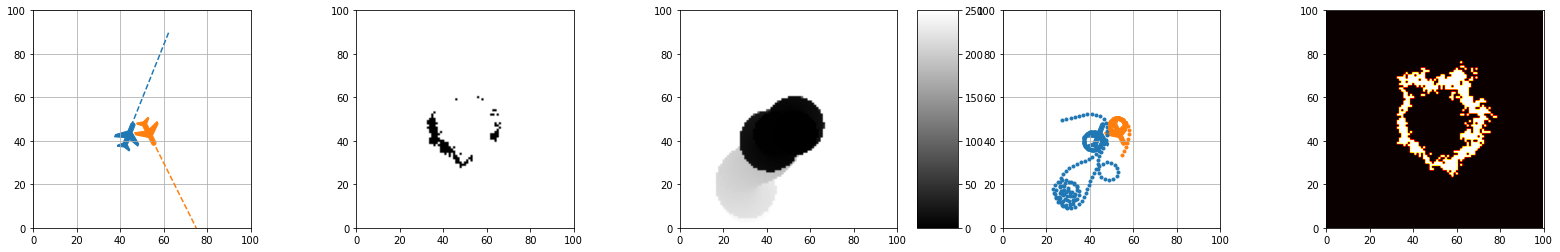

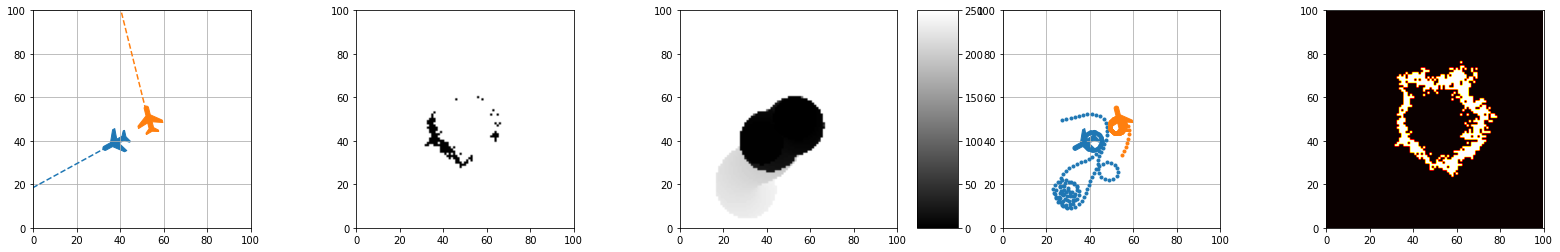

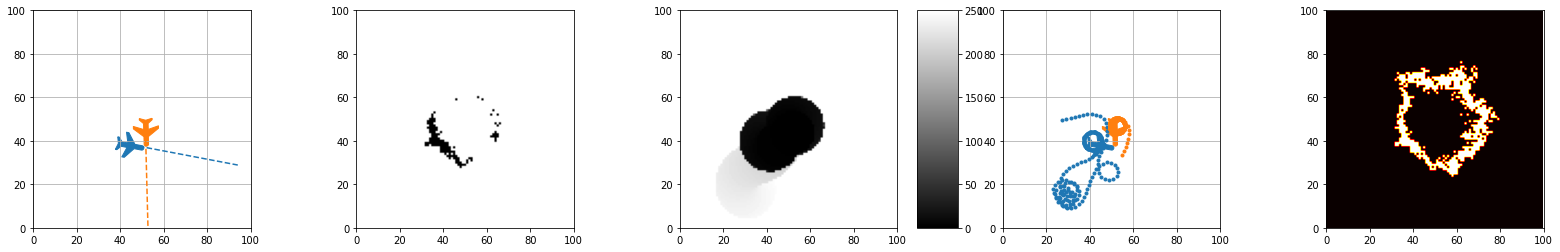

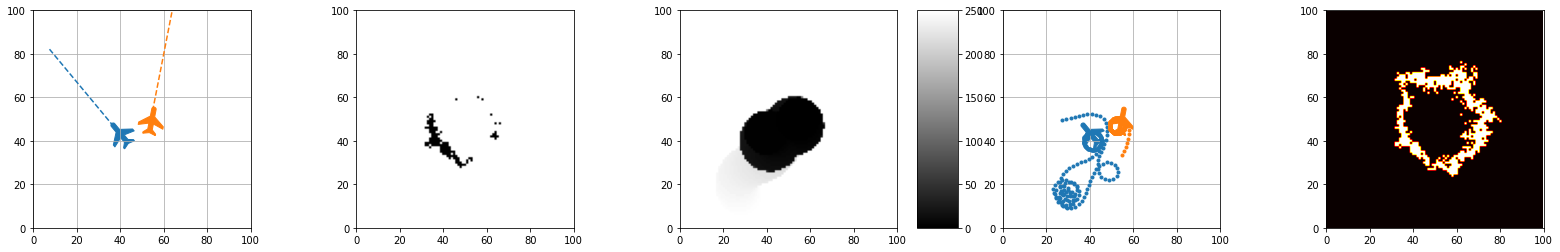

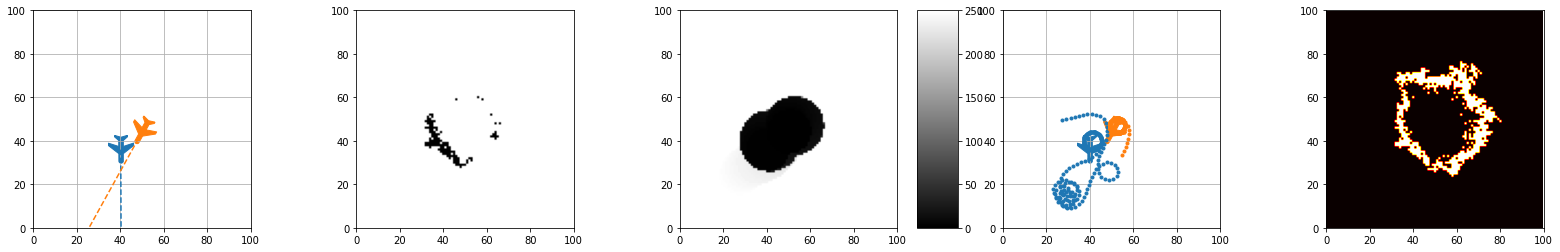

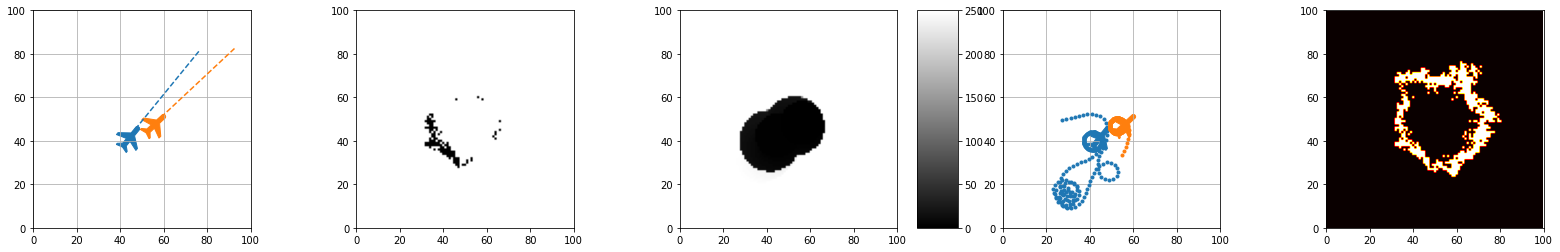

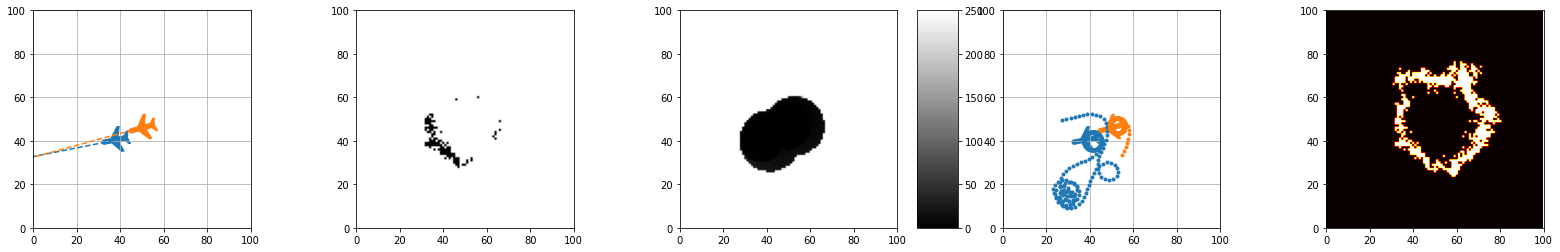

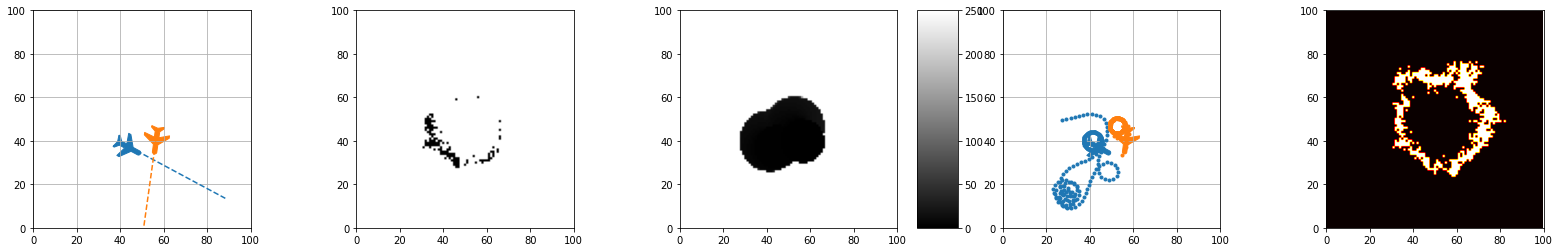

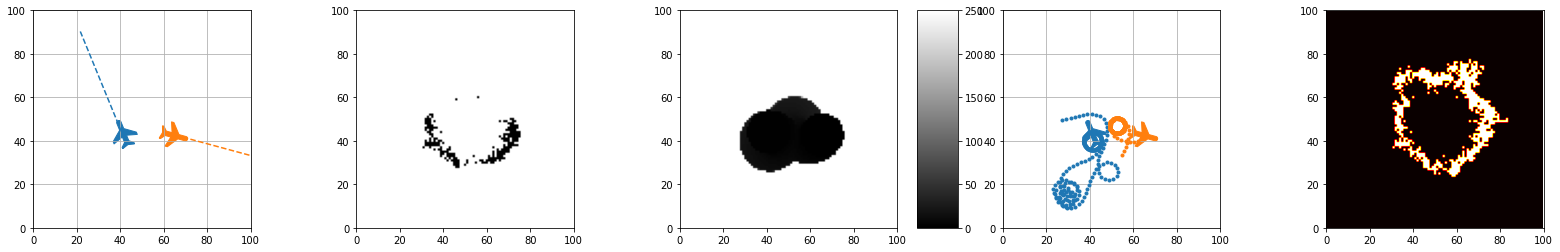

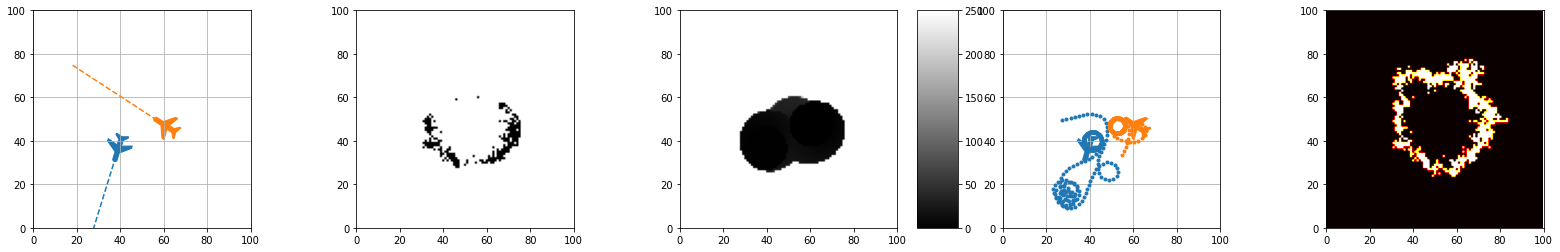

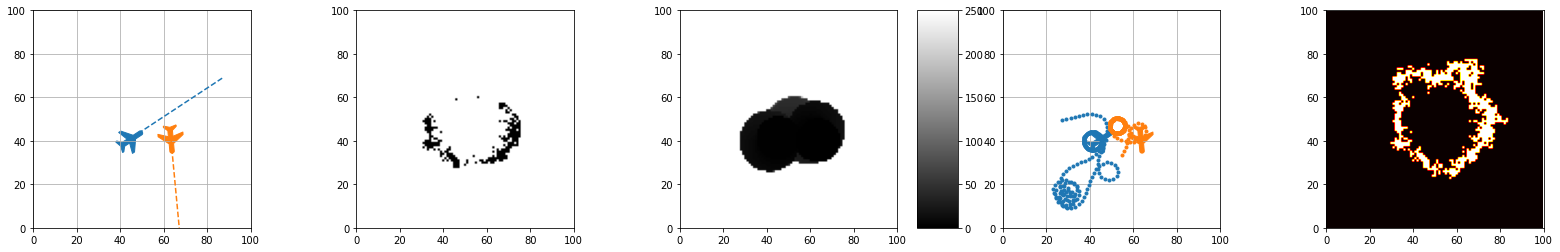

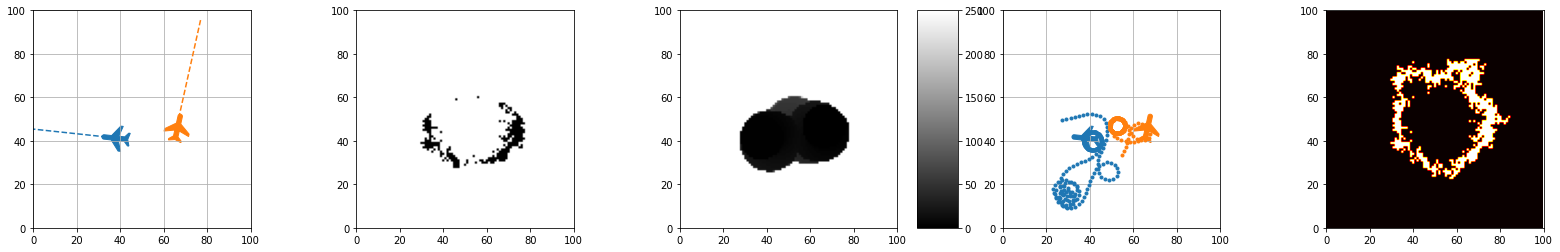

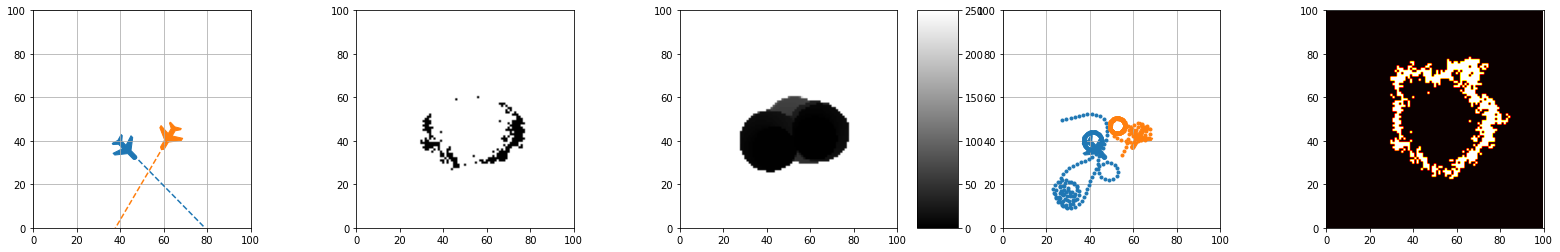

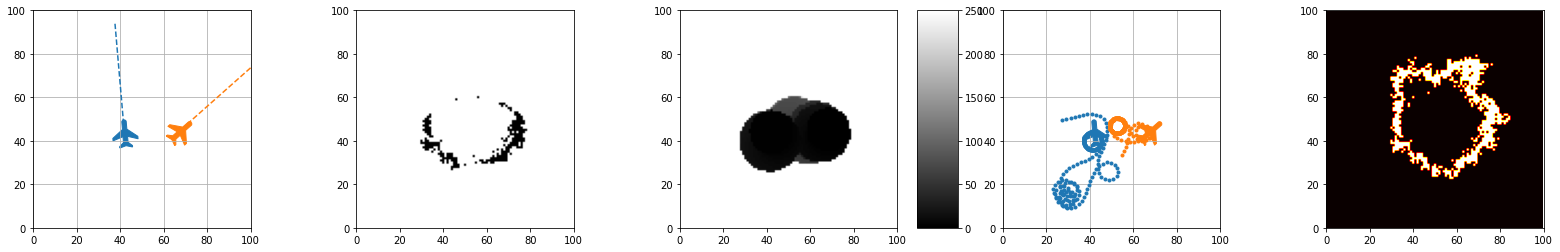

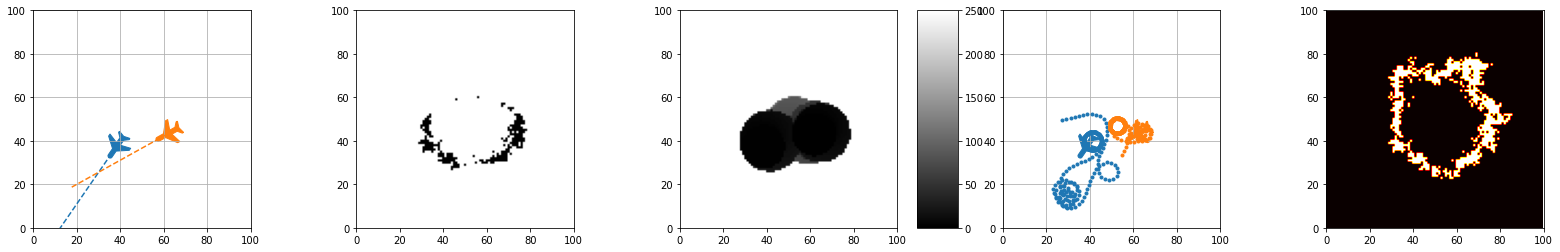

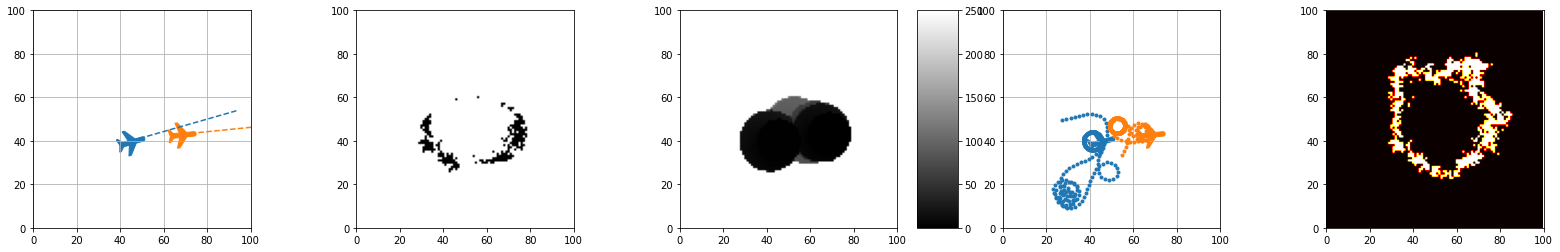

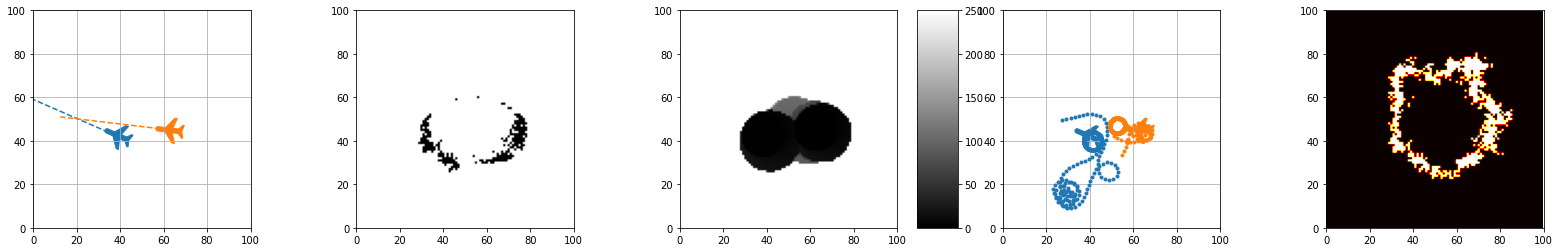

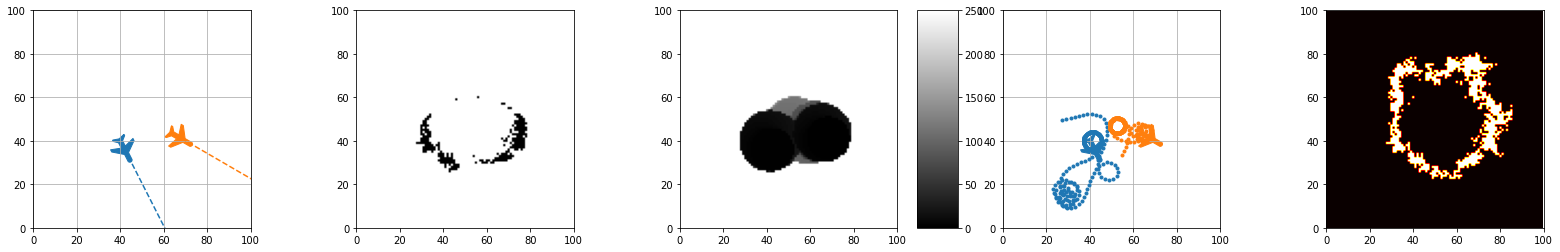

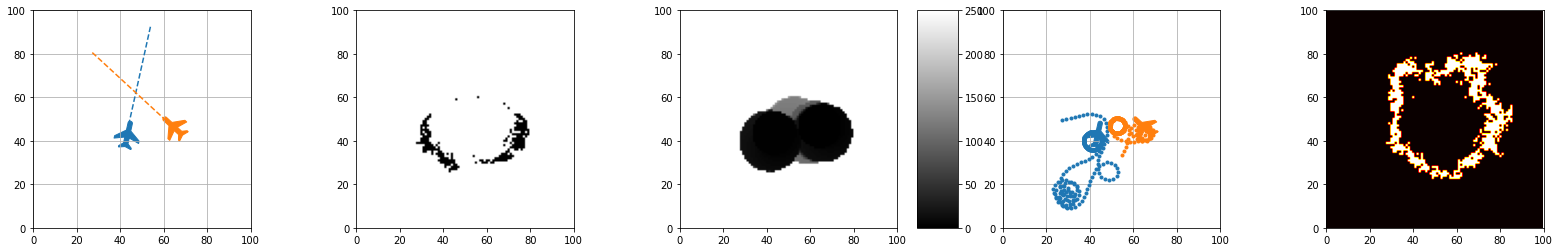

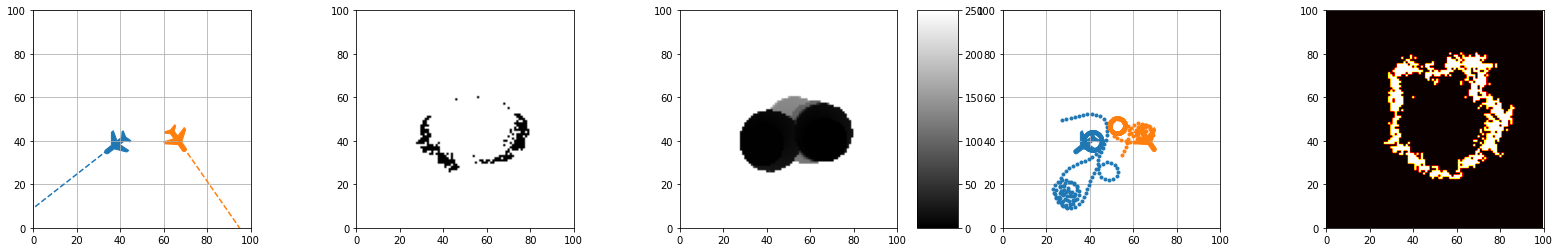

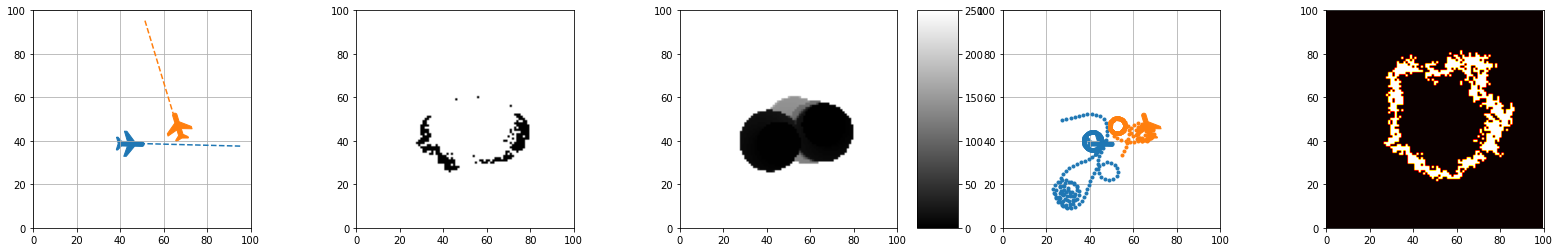

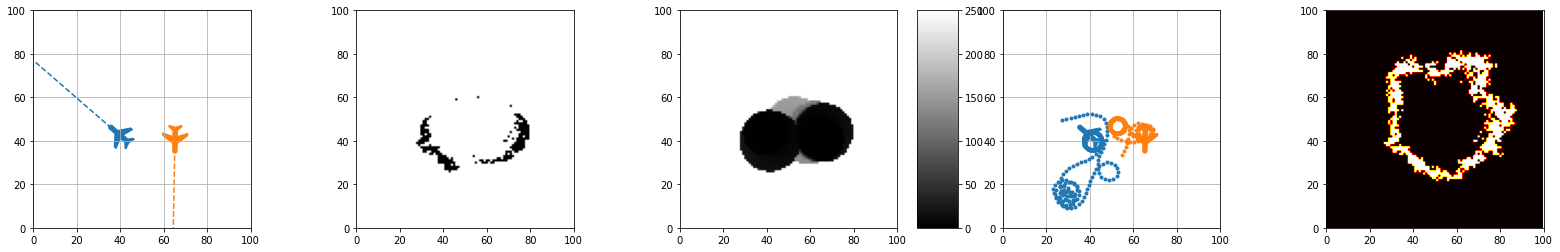

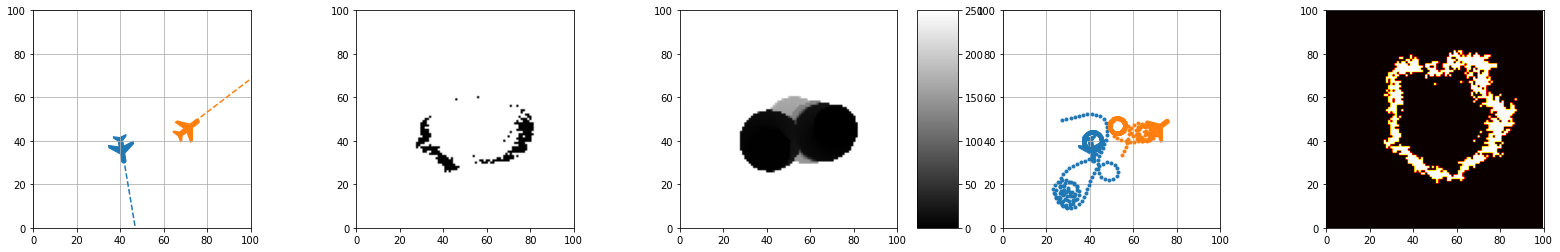

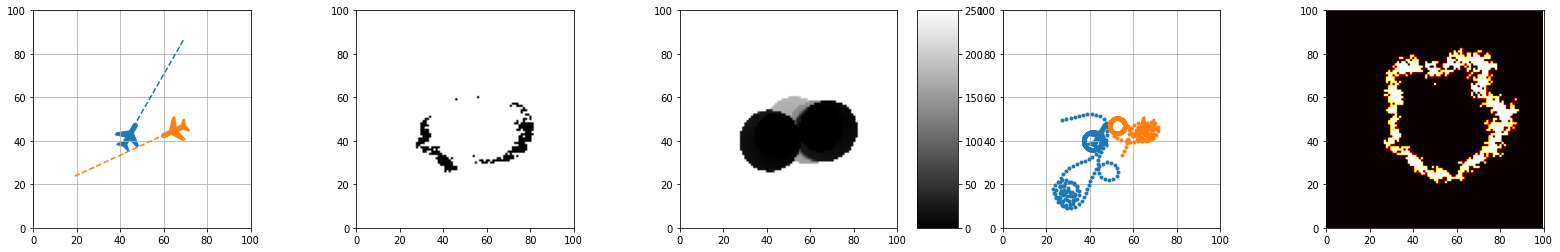

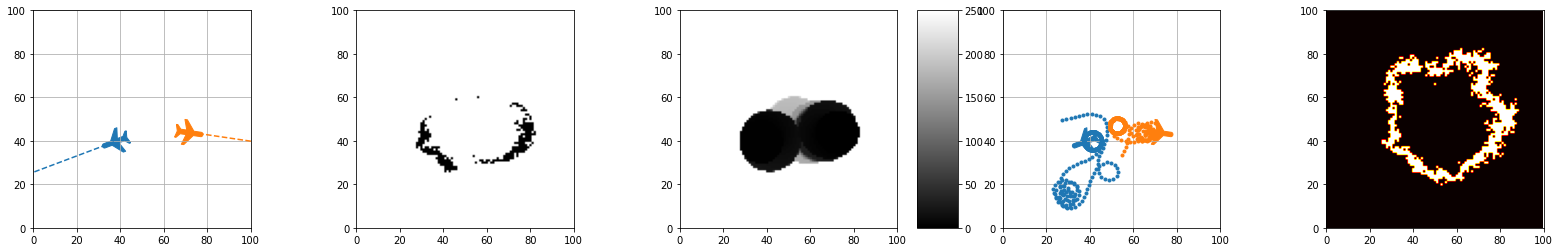

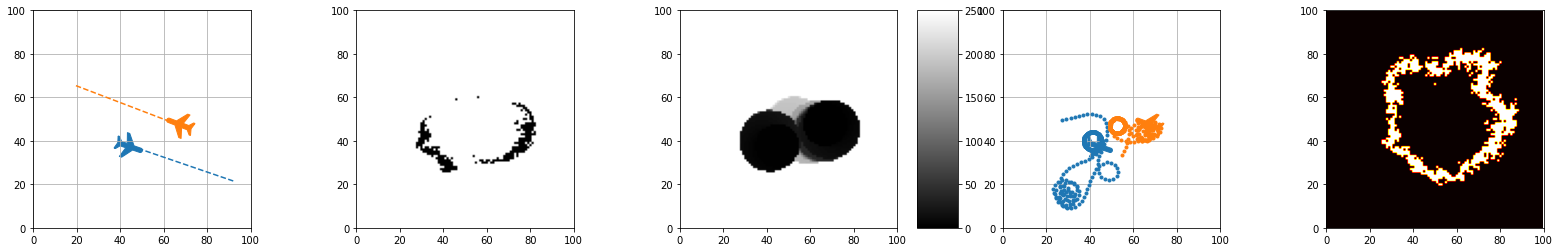

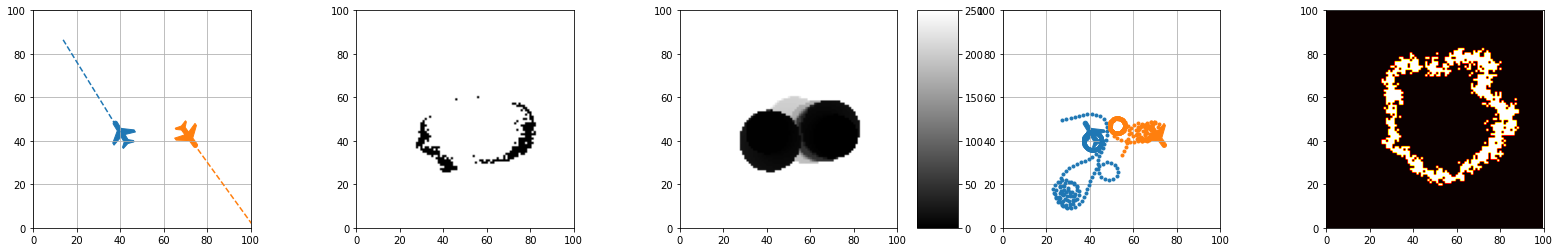

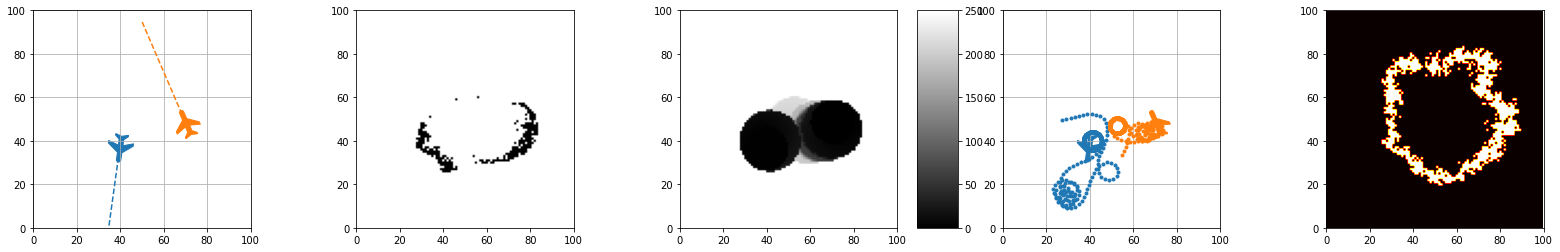

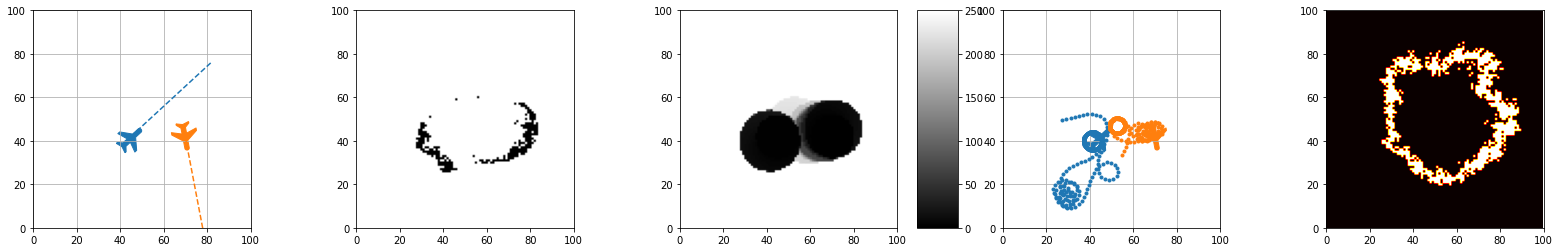

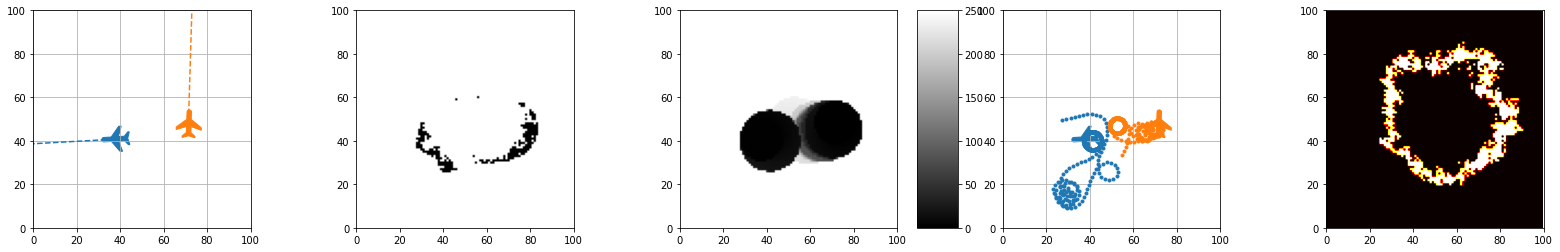

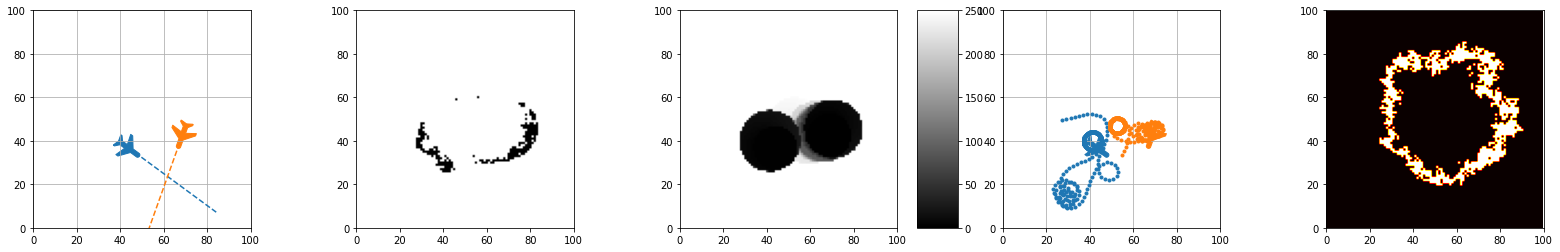

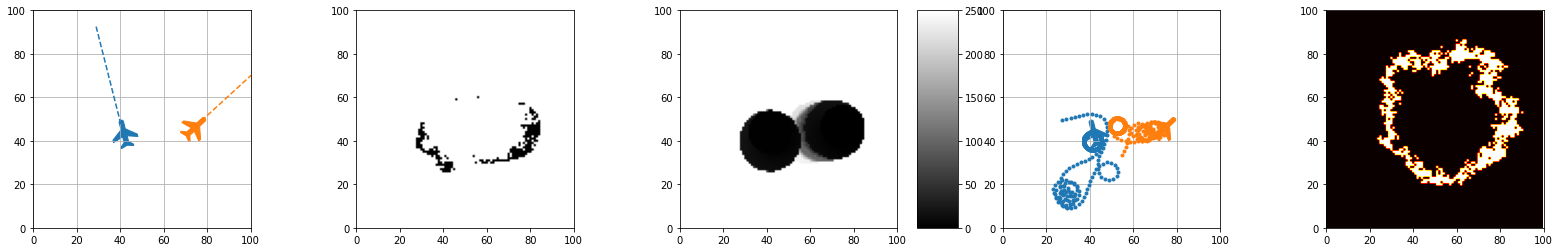

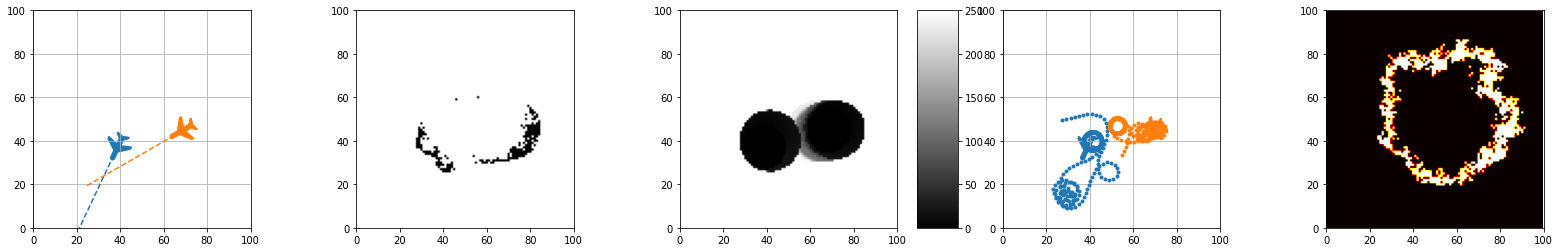

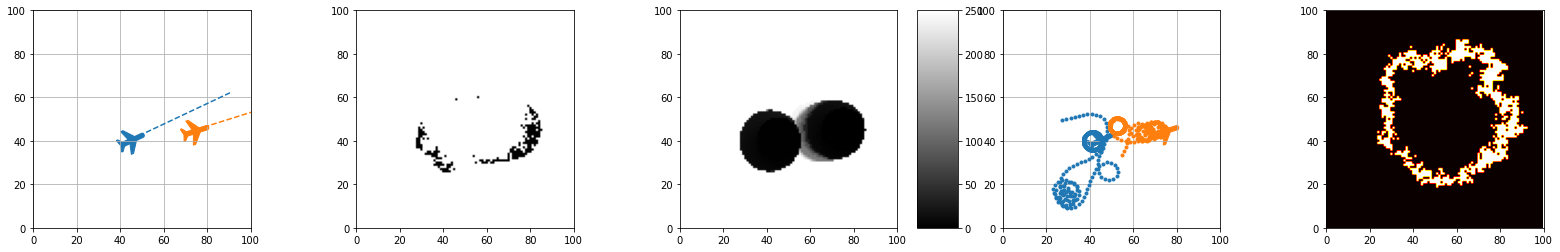

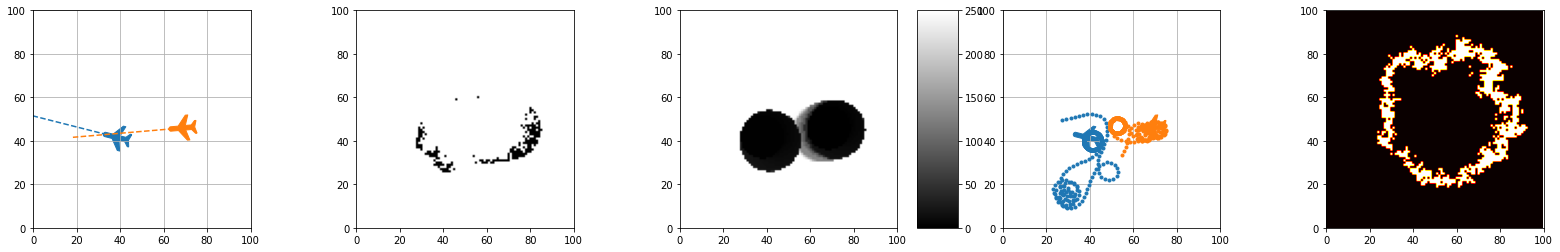

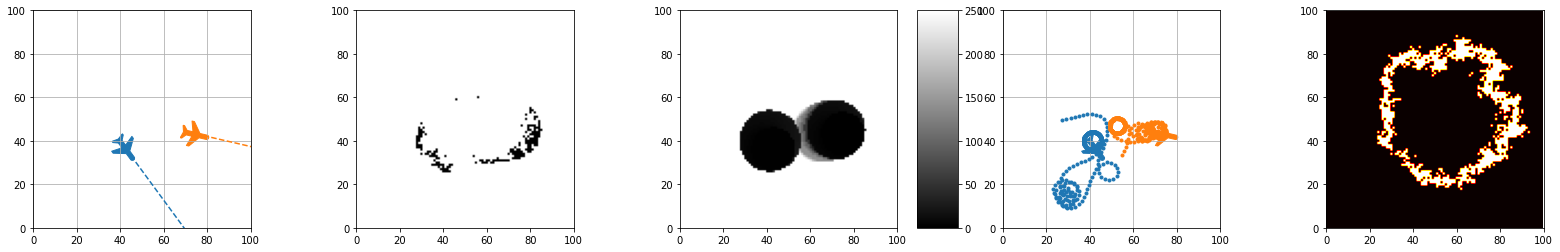

In [5]:
DT          = 0.5  # Time between wildfire updates            
DTI         = 0.1  # Time between aircraft decisions
fireEnv = ProbabilisticFireEnv(height, width)
dronesEnv = DronesEnv(height, width, DT, DTI) 
loss = None
i_episode = 1
images = []
observation = fireEnv.reset()
dronesEnv.reset(observation)
hidden_1 = target_net.init_hidden_state()
hidden_2 = target_net.init_hidden_state()
while True:

  observation = fireEnv.step()

  state_vector_1 = dronesEnv.drones[0].state
  map_1 = dronesEnv.drones[0].observation
  state_vector_1 = torch.tensor(state_vector_1, device=device, dtype=torch.float)
  map_1 = torch.tensor(map_1, device=device, dtype=torch.float)

  state_vector_2 = dronesEnv.drones[1].state
  map_2 = dronesEnv.drones[1].observation
  state_vector_2 = torch.tensor(state_vector_2, device=device, dtype=torch.float)
  map_2 = torch.tensor(map_2, device=device, dtype=torch.float)

  for i in range(int(DT/DTI)):

    action1, hidden_1 = target_net(map_1, state_vector_1, hidden_1)
    action2, hidden_2 = target_net(map_2, state_vector_2, hidden_2)
    action1 = action1.max(1)[1].view(1, 1)
    action2 = action2.max(1)[1].view(1, 1)
    dronesEnv.step([action1.item(), action2.item()], observation)

    next_state_vector_1 = dronesEnv.drones[0].state
    next_map_1 = dronesEnv.drones[0].observation

    next_state_vector_1 = torch.tensor(next_state_vector_1, device=device, dtype=torch.float)
    next_map_1 = torch.tensor(next_map_1, device=device, dtype=torch.float)

    next_state_vector_2 = dronesEnv.drones[1].state
    next_map_2 = dronesEnv.drones[1].observation

    next_state_vector_2 = torch.tensor(next_state_vector_2, device=device, dtype=torch.float)
    next_map_2 = torch.tensor(next_map_2, device=device, dtype=torch.float)

    state_vector_1 = next_state_vector_1
    state_vector_2 = next_state_vector_2

    map_1 = next_map_1
    map_2 = next_map_2

  if not fireEnv.fire_in_range(6):

    break
  
  fig, ax = plt.subplots(1, 5, figsize=(28, 4))
  dronesEnv.plot_drones(fig, ax[0])
  dronesEnv.plot_belief_map(fig, ax[1])
  dronesEnv.plot_time_elapsed(fig, ax[2])
  dronesEnv.plot_trajectory(fig, ax[3])
  fireEnv.plot_heat_map(fig, ax[4])
  fig.canvas.draw() 
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
  image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  images.append(image)
    

kwargs_write = {'fps':5.0, 'quantizer':'nq'}
imageio.mimsave('./example6.gif', images, fps=5)